### Imports

In [1]:
%load_ext cython

In [2]:
!python --version
!pip freeze | grep numpy;
!pip freeze | grep pandas;
!pip freeze | grep scipy;
!pip freeze | grep sklearn;
!pip freeze | grep matplotlib;
!pip freeze | grep Cython;
# !pip freeze | grep cupy;

Python 3.7.4
numpy==1.18.1
pandas==0.25.3
scipy==1.3.2
matplotlib==3.1.2
Cython==0.29.14


In [3]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import confusion_matrix
from numpy.random import multivariate_normal
from matplotlib import pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from numbers import Number
from typing import Iterable, Union

# import plotly.graph_objects as go

import time
from functools import partial

In [3]:
# import cupy as cp

In [3]:
# from numba import njit,jit

### Formulas

**Kernel Density**

Given a set of known samples $S = [s_1, s_2, ..., s_n]$, the Kernel Density Estimator (KDE) function can be used to predict the probability density for an arbitrary range of values, $X = [x_1, x_2,...,x_n]$, by mapping the KDE function over the range of values.

$$[x_1, x_2, ..., x_n] \xrightarrow{f(x, S)} [f(x_1, S), f(x_2, S), ..., f(x_n, S)]$$

<b>Fixed KDE </b>(Gaussian Kernel, Single or Multidimensional): <br>

An estimator for probability density, with a fixed $\sigma$:

$$\hat{f}(x,S) = \dfrac{1}{n \left(\sigma \sqrt{2\pi}\right)^m} \sum_{i=1}^{n} exp\left(\dfrac{{-\Vert x - s_i\Vert}^2}{2\sigma^2}\right)$$


$s_i$ : each sample in $S$, the set of collected samples <br>
$x$ : location or coordinates of estimated density, with dimensions matching each sample $s_i$ in $S$ <br>
$\sigma$ : standard deviation of S, (the bandwidth used for a gaussian kernel) <br>
m : dimension of vector space (i.e., dimensions of $x$)<br>
$n$ : number of samples, (the size of $S$) <br>

**Code**: In the Python code below, this equation is labelled as follows:

$$\hat{f}(x,S) = a \cdot \sum_{i=1}^{n} \left[exp\left(\dfrac{-\mathrm{norm}\_s_i}{\mathrm{exp\_denom}}\right)\right]$$

<p style='text-align:center'> $\hat{f}(x,S)$ = $a$ * np.sum( $ \bigg[ \bigg.$ np.exp$\big( \big.$-norm/exp_denom $\big. \big)$ for norm in norms $\bigg. \bigg]$ )</p>
<br>
norms: an array of normals for each $s_i$; <br>
$\quad$ e.g., norms = $\left[\right.$norm$(s_1), $ norm$(s_2), $ norm$(s_3),..., $ norm$(s_i),..., $ norm$(s_n) \left. \right]$<br>
$\quad\quad\quad$where norm$(s_i) = \Vert x - s_i\Vert^2$ = np.linalg.norm($x-s_i$)$^2$

<b>General KDE </b>(Gaussian Kernel, Single or Multidimensional): <br>

For Abramson and Silverman methods, a new $\sigma_i$ is calculated and substituted for $\sigma$ into the equation $\hat{f}(x,S)$ above. For Abramson's method, there is a different $\sigma_i$ for each $s_i$.  <br>

$$f(x,S) = \sum_{i=1}^{n} \dfrac{1}{n\left(\sigma_i \sqrt{2\pi}\right)^m}\cdot exp\left(\dfrac{{\Vert x - s_i\Vert}^2}{2\sigma_i^2}\right)$$


<b>Constant Bandwidth: Silverman's Method</b>

Best bandwidth based on Silverman's Rule of Thumb:

$$\sigma_{i} = \left(\dfrac{4\sigma^5}{3n}\right)^{\tfrac{1}{5}}$$

$\sigma_{i}$ : kernel bandwidth, used in General KDE <br>
$\sigma$ : sample standard deviation <br>
$n$ : sample size

*Note: Silverman's Bandwidth is still fixed for all $s_i$ in $S$*

<b>Variable Bandwidth: Abramson's Method</b>

Abramson's method uses variable bandwidths for each sample $s_i$, defined by:

$$\sigma_i = \sigma \cdot \left(\dfrac{\eta}{f_{fixed}(s_i)}\right)^{1/2}$$

$\sigma_i$ : Abramson bandwidth for $s_i \in S$, where $S$ is the set of all collected samples <br>
$\sigma$ : standard deviation of $S$, (original fixed bandwidth) <br>
$\eta$: mean of $f_{fixed}(s)$ for all samples $s$ in $S$<br>
$f_{fixed}(s_i)$ : fixed kernel density estimation of a given $s_i$

*Note: $\eta$ is a constant parameter, dependent on $S$*

$$\eta = \dfrac{1}{n} \sum_{i=1}^n f_{fixed}(s_i) \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$$ 

$$\quad = \dfrac{1}{n} \sum_{i=1}^n \left( \dfrac{1}{n \left(\sigma \sqrt{2\pi}\right)^m} \sum_{j=1}^{n} exp\left(\dfrac{{\Vert s_i - s_j\Vert}^2}{2\sigma^2}\right) \right) $$

$$\quad = \dfrac{1}{n^2 \left(\sigma \sqrt{2\pi}\right)^m} \sum_{i=1}^n \left( \sum_{j=1}^{n} exp\left(\dfrac{{\Vert s_i - s_j\Vert}^2}{2\sigma^2}\right) \right)$$

<p style='text-align:center'> $=$ a constant number based on $S$ $\quad\quad\quad\quad\quad$</p>

**Mean Square Error**:

Mean Square Error (MSE), a commonly used metric to evaluate density functions, is defined as follows:

$$ \mathrm{MSE} = \dfrac{1}{n} \sum_{i=1}^n \left[\hat{f}(x_i) - f(x_i)\right]^2$$

$\hat{f}(x)$ : estimator of $f(x)$ <br>
$f(x)$ : true distribution of $x$ <br>
$n$ : number of samples of $x \in X$

### KDE Functions (Completely Vectorized, with Cython)

#### cython funcs

The following functions are parts of `KDE_fixed_arr()` and `KDE()` that were written in Cython to avoid using a terribly slow Python for-loop.

In [4]:
%%cython
cimport cython
import numpy as np
from libc.stdio cimport printf

ctypedef fused dfloat:
    cython.float
    cython.double
    int
    
# used in KDE_fixed_arr()
def kde_loop_multi(dfloat[:,:] S, dfloat a, dfloat exp_denom):
    "Computes norms and KDE values in C for KDE_fixed, where S is a multidimensional array"
    
    # transpose S to (num_samples, dimensions)
    # subtract (broadcast) and take norm
    # transpose norm back to (dimensions, samples) (unnecessary step)
    # sum norms for each i --> length of a norm = number of dimensions
    # sum along dimensions (axis 0) --> length(vals) = number of samples
    
    S = np.array(S).T # shape (n,m)
    vals = []
    for X in S:
        X = np.array(X) # shape (m,)
        norms = np.abs(X-S)**2 # shape (n,m)
#         norms = np.linalg.norm(X-S)**2
        norms = np.sum(np.array(norms), axis=1) # sum along dimensions; shape (n,)
        kde_val = a*np.sum(np.exp(-norms/exp_denom),axis=0) # shape (n,)
        vals += [kde_val] # --> (shape n,n)
#     result = np.sum(np.array(vals), axis=1) # sum for each i in n; shape (n,)

    return vals # shape (n,)


# used in KDE_fixed_arr()
def kde_loop_onedim(dfloat[:] S, dfloat a, dfloat exp_denom):
    "Computes norms and KDE values in C for KDE_fixed, where S is a one-dimensional array"
    S = np.array(S) # shape (n,)
    vals = []
    for X in S:
        X = np.array(X) # shape (1,)
        norms = np.abs(X-S)**2 # shape (n,)
#         norms = np.linalg.norm(X-S)**2
        norms = np.array(norms) # shape (n,)
        kde_val = a*np.sum(np.exp(-norms/exp_denom)) # shape (1,)
        vals += [kde_val] # --> shape (n,)
    return np.array(vals) # shape (n,)


# used in KDE()
def general_kde_loop_multidim(dfloat[:,:] S, dfloat[:] a, dfloat[:] exp_denom):
    """norm loop computation for multidimensional S, (where S is the set of samples); used in KDE()
    
    Computes norms, then computes KDE values for each sample"""
    
    # transpose to (num_samples, dimensions)
    # subtract (broadcast) and take norm
    # transpose norm back to (dimensions, samples) (unnecessary step)
    # sum norms for each i --> length of a norm = number of dimensions
    # sum along dimensions (axis 0) --> length(vals) = number of samples
    
    S = np.array(S).T # shape (n,m)
    a = np.array(a) # shape (n,)
    exp_denom = np.array(exp_denom) # shape (n,)
    
    norms = []
    for j in range(len(S)):
        norm = np.abs(np.array(S[j])-S)**2 # shape (n,m); S[j]: shape (1,)
        norm = np.sum(np.array(norm), axis=1) # sums norms across dimensions; shape (n,)
        norms += [norm] # --> shape (n,n), coordinate (j,i) or (i,j); symmetric matrix
        
    kde_vals = []
    for i in range(len(S)):
        kde_val = a[i] * np.exp(-norms[i]/exp_denom[i]) # shape (n,) (shapes a[i]: 1, exp_denom[i]: 1, norms[i]: (n,))
        kde_vals += [kde_val] # --> shape (n,n), coordinate (i,j)
        
    kde_vals = np.sum(np.array(kde_vals), axis=0) # shape (n,); kde value for each sample    
    return kde_vals # shape (n,)


# used in KDE()
def general_kde_loop_onedim(dfloat[:] S, dfloat[:] a, dfloat[:] exp_denom):
    """norm loop computation for one-dimensional S, (where S is the set of samples); used in KDE()
    
    Computes norms, then computes KDE values for each sample"""
    S = np.array(S) # shape (n,)
    a = np.array(a) # shape (n,)
    exp_denom = np.array(exp_denom) # shape (n,)
    
    norms = []
    for j in range(len(S)):
#         norms = np.abs(X-S)**2
        norm = np.abs(np.array(S[j])-S)**2 # shape (n,); shape of S[i]: 1
        norms += [norm] # shape (n,n)
        
    kde_vals = []
    for i in range(len(S)):
        kde_val = a[i] * np.exp(-norms[i]/exp_denom[i]) # shape (n,) (shapes a[i]: 1, exp_denom[i]: 1, norms[i]: (n,))
        kde_vals += [kde_val] # --> shape (n,n), coordinate (i,j)
        
    kde_vals = np.sum(np.array(kde_vals), axis=0) # shape (n,); kde_value for each sample
    return np.array(kde_vals) # shape (n,)

#### numpy funcs

In [5]:
#
def pdf(x:Iterable,dim='univariate') -> Iterable:
    "Probability Density Function for a normal distribution, x: an array of numbers"
    if dim=='univariate':
        x = np.array(x)
        𝜇 = np.mean(x)
        𝜎 = np.std(x) 
        𝜋 = np.pi
        return (1/(np.sqrt(2*𝜋*𝜎**2)))*(np.exp(-((x - 𝜇)**2)/(2*𝜎**2)))
    elif dim=='multivariate':
        return
    else:
        raise TypeError('`dim` must be either "univariate" or "multivariate"')

In [6]:
def get_mn(S):
    "gets number of samples and dimension of S; used for debugging purposes"
    def ismulti(A): return len(np.array(A).shape) > 1 # checks if A is multi-dimensional
    
    is_multidimensional = ismulti(S)
    
    m = len(S) if is_multidimensional else 1 # dimensions
    n = len(S[0]) if is_multidimensional else len(S) # number of samples
    print("dimension:",m)
    print("samples",n)
    return m,n

In [7]:
# 
def KDE_fixed_arr(S:Iterable, m=None, h=None, a=None) -> Number:
    """A general fixed KDE with gaussian kernel, returns an array of all KDE values for each X in S
    
    S: coordinates for all samples, (e.g., S = ([s1,s2,s2...]_x, [s1,s2,s3...]_y, [s1,s2,s3...]_z,...))
         shape of S: (X, Y, Z,...), i.e., coordinate axes by number of samples
    m: dimension of items in S; used to ensure consistency for dimensions of S (if not None)
    h: bandwidth, (if None, h will equal the standard deviation of S)
    a: 1/((n*𝜎*sqrt(2𝜋))**m), (if None, 'a' is computed automatically)
    """
    S = np.array(S).astype(np.float64)
    
    def ismulti(A): return len(np.array(A).shape) > 1 # checks if A is multi-dimensional
    
    is_multidimensional = ismulti(S)
    
    # CHECK SHAPE OF S
    if ((m is not None) and is_multidimensional):
        # (Ensure S is a list of [xs,ys,zs,...] for each dimension 'x','y','z',... of samples in S)
#         S = np.transpose(S) if (m != len(S)) else np.array(S)
        if (m != len(S)):
            S = np.transpose(S)
            print("DIMENSION MISMATCH: S TRANSPOSED")
        else:
            S = np.array(S)
        if (m != len(S)):
            raise TypeError(f'Dimension Mismatch: Items in S were originally {len(S[0])}-dimensional. Transpose(S) is {len(S)}-dimensional. \nNeither one matches m={m} ({m}-dimensional)')
    
    𝜎 = np.std(S) if (h is None) else h # standard deviation of S or a given bandwidth
    𝜋 = np.pi
    m = len(S) if is_multidimensional else 1 # dimensions
    n = len(S[0]) if is_multidimensional else len(S) # number of samples
    
    a = 1/(n*(𝜎*np.sqrt(2*𝜋))**m) if (a is None) else a
    exp_denom = 2*(𝜎**2)
    
    if is_multidimensional:
        kde_vals = kde_loop_multi(S, a, exp_denom) # shape (n,)
    else:
        kde_vals = kde_loop_onedim(S, a, exp_denom) # shape (n,)

    return np.array(kde_vals)

In [8]:
#
def eta(S:Iterable, m=None, a=None) -> Number:
    """Compute 𝜂 for calculating Abramson's bandwidth
    
    Note: the parameter 'a' is used for calculating all fixed KDE values, but it only needs to be computed once
    
    S: set of all samples
    m: dimension of items in S; used to ensure consistency for dimensions of S (if not None)
    a = 1/(n*(𝜎*np.sqrt(2*𝜋))**m), computed automatically if None
    
    Examples:
        m=1, S=[x1,x2,x3,...,x_n]
        m=2, S=[[x1,x2,x3,...,x_n],[y1,y2,y3,...,y_n]]
        m=3, S=[[x1,x2,...,x_n],[y1,y2,...,y_n],[z1,z2,...z_n]]
            where x1, x2, x3, etc. are numbers
    """
    S = np.array(S).astype(np.float64)
    
    def ismulti(A): return len(np.array(A).shape) > 1 # checks if A is multi-dimensional
    
    is_multidimensional = ismulti(S)
    
    # CHECK SHAPE OF S
    if ((m is not None) and is_multidimensional):
        # (Ensure S is a list of [xs,ys,zs,...] for each dimension 'x','y','z',... of samples in S)
#         S = np.transpose(S) if (m != len(S)) else np.array(S)
        if (m != len(S)):
            S = np.transpose(S)
            print("DIMENSION MISMATCH: S TRANSPOSED")
        else:
            S = np.array(S)
        if (m != len(S)):
            raise TypeError(f'Dimension Mismatch: Items in S were originally {len(S[0])}-dimensional. Transpose(S) is {len(S)}-dimensional. \nNeither one matches m={m} ({m}-dimensional)')
    
    # Compute 'a' if not given
    if a is None:
        𝜎 = np.std(S) # standard deviation of S
        𝜋 = np.pi
        m = len(S) if is_multidimensional else 1 # dimensions
        n = len(S[0]) if is_multidimensional else len(S) # number of samples
        
        a = 1/(n*(𝜎*np.sqrt(2*𝜋))**m)  # parameter 'a'

    # Compute 𝜂, where 'a' is only computed once
    𝜂 = np.array(KDE_fixed_arr(S,m=m)).mean() # a*...(a=a)
    
    return 𝜂

In [9]:
# 
def KDE(S:Iterable, bw:str = 'silverman', m=None, a=None) -> Number:
    """General KDE with Silverman's or Abramson's Bandwidth and Gaussian kernel
    
    S: coordinates for all samples, (e.g., S = ([s1,s2,s2...]_x, [s1,s2,s3...]_y, [s1,s2,s3...]_z,...))
    bw: bandwidth method ('silverman', 'abramson')
    m: dimension of items in S; used to ensure consistency for dimensions of S (if not None)
    a = 1/(n*(𝜎*np.sqrt(2*𝜋))**m), computed automatically if None
    """
    S = np.array(S).astype(np.float64)
    
    def ismulti(A): return len(np.array(A).shape) > 1 # checks if A is multi-dimensional
    
    is_multidimensional = ismulti(S)
    
    # CHECK SHAPE OF S (m,n)
    if ((m is not None) and is_multidimensional):
        # (Ensure S is a list of [xs,ys,zs,...] for each dimension 'x','y','z',... of samples in S)
#         S = np.transpose(S) if (m != len(S)) else np.array(S)
        if (m != len(S)):
            S = np.transpose(S)
            print("DIMENSION MISMATCH: S TRANSPOSED")
        else:
            S = np.array(S)
        if (m != len(S)):
            raise TypeError(f'Dimension Mismatch: Items in S were originally {len(S[0])}-dimensional. Transpose(S) is {len(S)}-dimensional. \nNeither one matches m={m} ({m}-dimensional)')
    
    
    𝜎 = np.std(S)
    𝜋 = np.pi
    m = len(S) if is_multidimensional else 1 # dimensions
    n = len(S[0]) if is_multidimensional else len(S) # number of samples
    
    if a is None:
        a_denom = n*(𝜎*np.sqrt(2*𝜋))**m
        a = 1/a_denom if not (a_denom==0) else 0
    
    if bw=='silverman':
        # (n * (d + 2) / 4.)**(-1. / (d + 4)) # from scipy.stats.gaussian_kde
        
#         𝜎_silverman = (4*(𝜎**5)/(3*n))**(1/5) # compute silverman's bandwidth
        h = (n * (m + 2) / 4.)**(-1. / (m + 4))
        return KDE_fixed_arr(S=S, h=h, m=m) # a=a
    
    elif bw=='silverman2':
        # (n * (d + 2) / 4.)**(-1. / (d + 4)) # from scipy.stats.gaussian_kde
        
        h = (4*(𝜎**5)/(3*n))**(1/5) # compute silverman's bandwidth # original 𝜎_silverman
#         h = (n * (m + 2) / 4.)**(-1. / (m + 4))
        return KDE_fixed_arr(S=S, h=h, m=m) # a=a
    
    elif bw=='abramson':
        𝜂 = eta(S=S, m=m) # eta, a constant # a=a
        
#         norms = np.abs(X-S)**2
#         norms = np.sum(np.transpose(norms), axis=1) if is_multidimensional else np.array(norms) 
                # sum across dimensions, returns array of len(S)
        
        
        𝜎_i = 𝜎*np.sqrt(𝜂/KDE_fixed_arr(S=S)) # a=a
        𝜎_i = np.array(𝜎_i) # array, shape (n,)
#         print('𝜎_i',𝜎_i)
        
        a_i = 1/(n*(𝜎_i*np.sqrt(2*𝜋))**m) # shape (n,)
        exp_denom_i = 2*(𝜎_i**2) # shape (n,)
        
        # get norms for each sample in S 
        if is_multidimensional:
            result = general_kde_loop_multidim(S, a_i, exp_denom_i) # array, shape (n,)
        else:
            result = general_kde_loop_onedim(S, a_i, exp_denom_i) # array, shape (n,)
        
        result = np.array(result) # array, shape (n,)
        
        # DEBUG
#         objs = [𝜎_i, a_i, exp_denom_i, norms]
#         names = ["𝜎_i", "a_i", "exp_denom_i", "norms"]
#         errdict = {n:len(o) for (n,o) in zip(names,objs)}
#         print(errdict)
#         print("is_multidimensional: ", is_multidimensional)
#         print("\nabram result",result)
        
        return result
    
    else:
        raise TypeError("'bw' must equal either 'silverman' or 'abramson'")


In [10]:
def MSE(predicted_density, true_density):
    """Mean Square Error"""
    predicted_density = np.array(predicted_density)
    true_density = np.array(true_density)
    mse = ((predicted_density-true_density)**2).mean()
    return mse

In [11]:
# def silver_band(n, d):
#     "n: number of samples, d: dimensions"
#     return (n * (d + 2) / 4.)**(-1. / (d + 4))

### Results 2D

Sample Size: 10000
Condition: 1


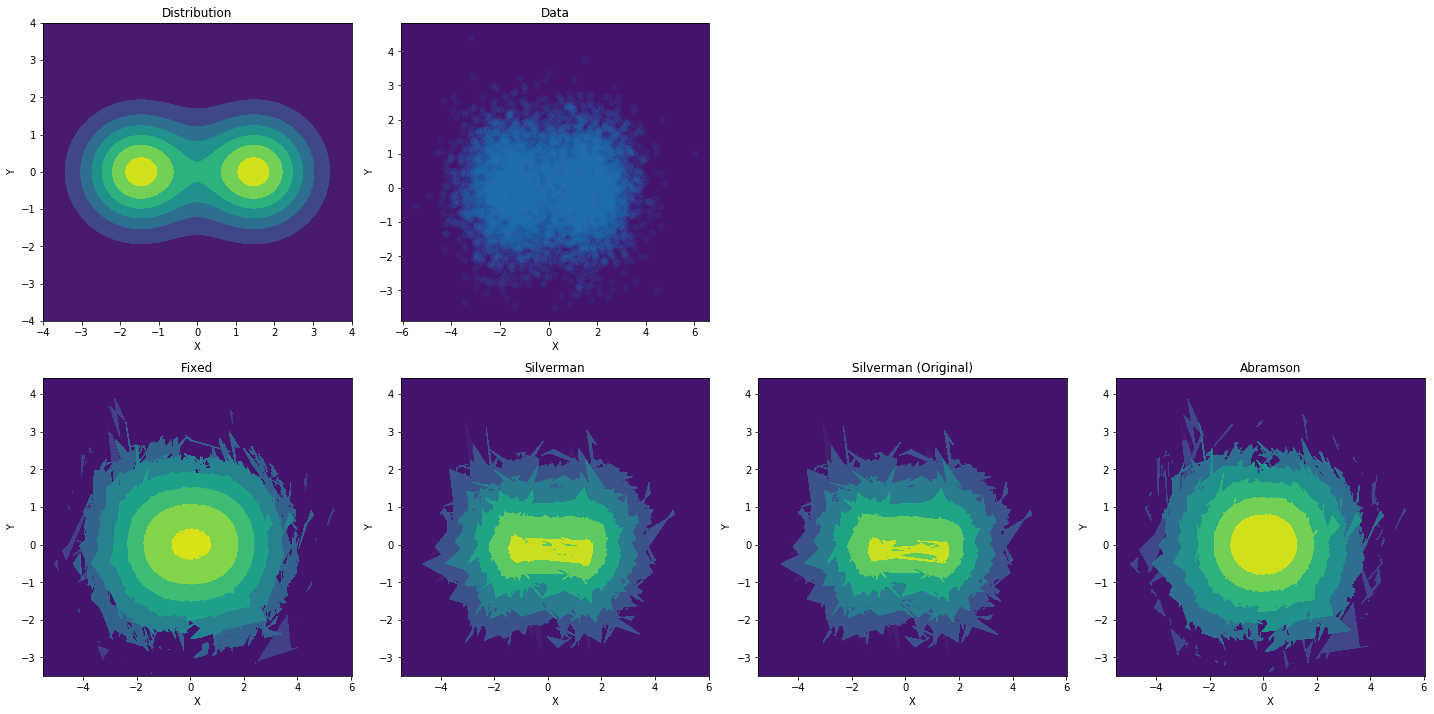

Sample Size: 10000
Condition: 2


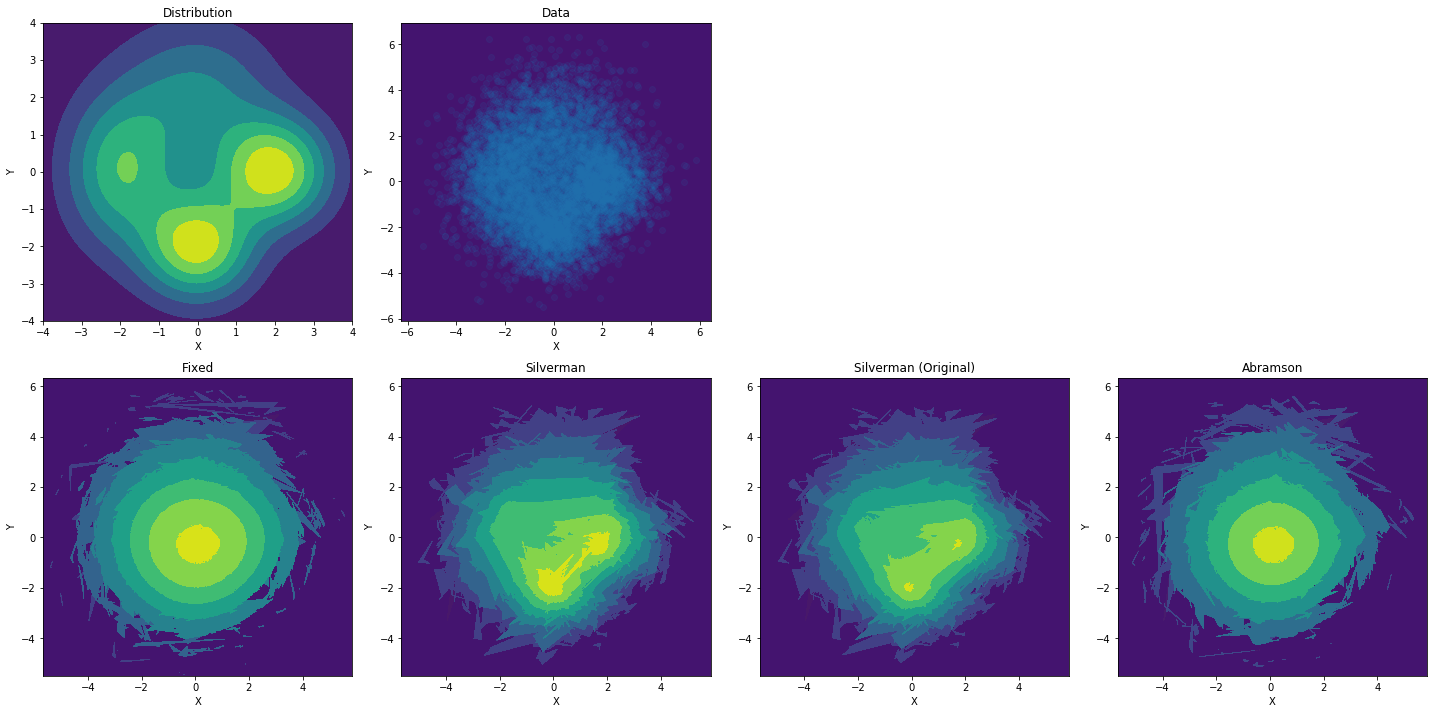

Sample Size: 10000
Condition: 3


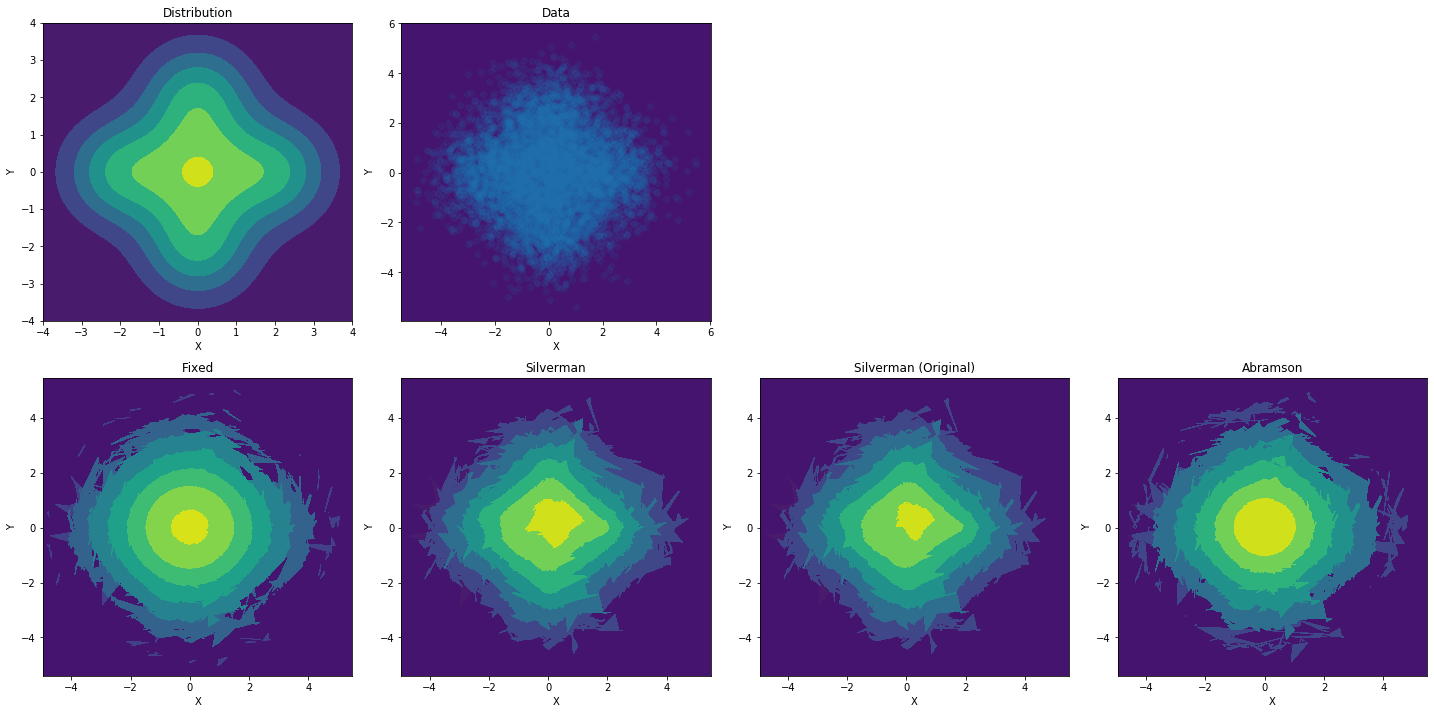

In [11]:
# COMPUTE AND DISPLAY 2D KDE PLOTS

for condition in [1,2,3]:
    
    dim = 100
    num_samples = dim**2
    print(f"Sample Size: {num_samples}")
    
    # GENERATE COORDINATES

    num_samples = dim**2

    x = y = np.linspace(-4,4,dim)
    X,Y = np.meshgrid(x,y)
    X,Y = X.flatten(), Y.flatten()
    XY = np.array([X,Y]).T
    
    # CONDITION PARAMETERS
    
    if condition == 1:
        print(f'Condition: {condition}')
        means = [[-1.5,0],[1.5,0]]
        covs = [
            [[1,0],[0,1]],
            [[1,0],[0,1]],
               ]
    #     N = 1500
        N = num_samples // len(covs)

    elif condition == 2:
        print(f'Condition: {condition}')
        means = [[-2,0],[2,0],[0,2],[0,-2]]
        covs = [
            [[1,0],[0,2]],
            [[1,0],[0,1]],
            [[2,0],[0,2]],
            [[1,0],[0,1]]
               ]
    #     N = 500
        N = num_samples // len(covs)

    else:
        print(f'Condition: 3')
        means = [[-2,0],[2,0],[0,2],[0,-2],[0,0]]
        covs = [
            [[1,0],[0,1]],
            [[1,0],[0,1]],
            [[1,0],[0,1]],
            [[1,0],[0,1]],
            [[1,0],[0,1]]
               ]
    #     N = 500
        N = num_samples // len(covs)

    # GENERATE DATA AND DESIRED DISTRIBUTION DENSITY
        
    datas = [multivariate_normal(mean=means[0],cov=covs[0],size=N)]
    densities = stats.multivariate_normal.pdf(x=XY, mean=means[0], cov=covs[0])

    for mean,cov in zip(means[1:], covs[1:]):
        datas += [multivariate_normal(mean=mean,cov=cov,size=N)]
        densities += stats.multivariate_normal.pdf(x=XY, mean=mean, cov=cov)

    data = np.vstack(np.array(datas))
    density = np.vstack(np.array(densities))

    xline,yline, density= map(lambda A: A.reshape(dim,dim), [X,Y,density])
    # xline, yline: meshgrid linespace for x and y axes
    # pdf_density: desired distribution of generated data
    
    # KDE COMPUTATIONS

    X,Y = data[:,0], data[:,1]
    Z = KDE_fixed_arr(S=[X,Y],m=2)
    Z2 = KDE(S=[X,Y],m=2,bw='silverman')
    Z3 = KDE(S=[X,Y],m=2,bw='silverman2')
    Z4 = KDE(S=[X,Y],m=2,bw='abramson')
    X,Y,Z,Z2,Z3,Z4 = map(lambda A: A.reshape(dim,dim), [X,Y,Z,Z2,Z3,Z4]) # reshape

    
    # PLOTS

    method_data = {'Distribution':[xline,yline,density],
                   'Data':[X,Y],
                   'Fixed': [X,Y,Z],
                   'Silverman':[X,Y,Z2],
                   'Silverman (Original)':[X,Y,Z3],
                   'Abramson':[X,Y,Z4]
                  }
    method_names = list(method_data.keys())

    plt.figure(figsize=(20,10))
    
    jump = 0 # used to move plots to next line
    for i in range(len(method_names)):
        method_name = method_names[i]
        ax = plt.subplot(f'24{i+1+jump}')

        if method_name == 'Data':
            plt.scatter(*method_data[method_name],alpha=0.1)
            jump += 2
        else:
            ax.contourf(*method_data[method_name])

        ax.set_title(f"{method_name}")
        ax.set(xlabel="X", ylabel="Y")
        ax.set_facecolor('#44146f')

    plt.tight_layout(pad=1.0)
    plt.show()


# # pdf
# plt.contourf(xline,yline,pdf_density)
# plt.show()

# # fixed
# plt.figure(figsize=(4,4))
# plt.contourf(X,Y,Z)
# plt.show()

# # silverman
# plt.figure(figsize=(4,4))
# plt.contourf(X,Y,Z2)
# plt.show()

# # silverman (original)
# plt.figure(figsize=(4,4))
# plt.contourf(X,Y,Z3)
# plt.show()

# # abramson
# plt.figure(figsize=(4,4))
# plt.contourf(X,Y,Z4)
# plt.show()


### Results (1D)

____________________________________________________________________________________________________


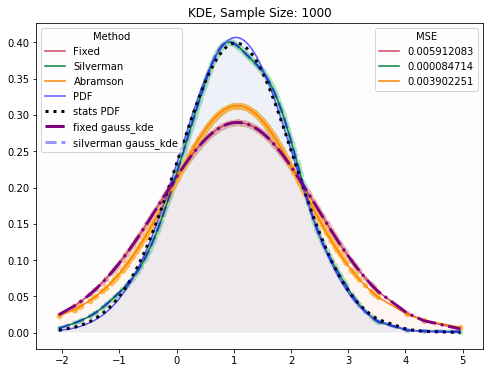


Time
-----------------------
PDF:        0.000064 s
KDE Fixed:  0.025890 s
Silverman:  0.025970 s
Abramson:   0.075414 s
Total:      0.127338 s
-----------------------
____________________________________________________________________________________________________


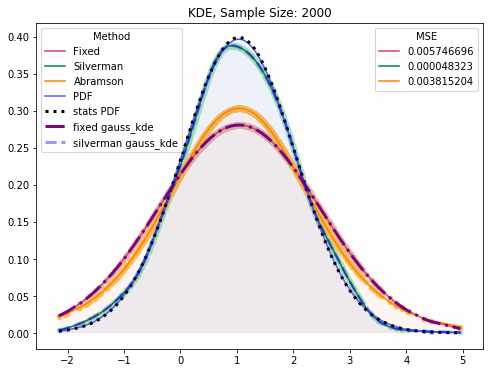


Time
-----------------------
PDF:        0.000098 s
KDE Fixed:  0.083620 s
Silverman:  0.083180 s
Abramson:   0.259938 s
Total:      0.426836 s
-----------------------
____________________________________________________________________________________________________


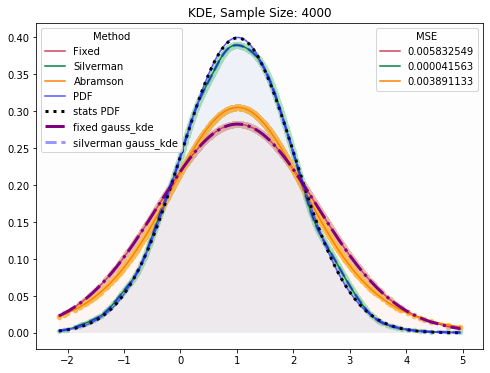


Time
-----------------------
PDF:        0.000112 s
KDE Fixed:  0.270934 s
Silverman:  0.271519 s
Abramson:   0.900646 s
Total:      1.443211 s
-----------------------
____________________________________________________________________________________________________


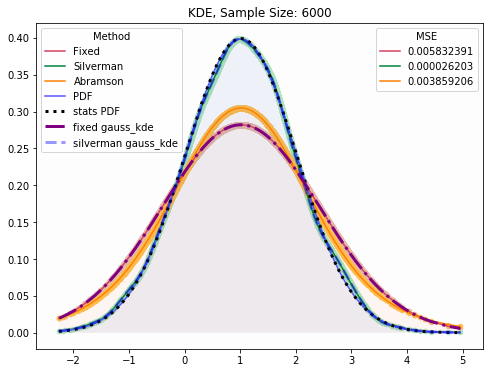


Time
-----------------------
PDF:        0.000151 s
KDE Fixed:  0.581846 s
Silverman:  0.573715 s
Abramson:   1.934559 s
Total:      3.090271 s
-----------------------
____________________________________________________________________________________________________


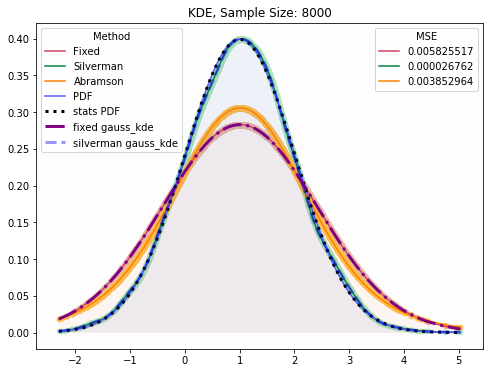


Time
-----------------------
PDF:        0.000203 s
KDE Fixed:  1.009091 s
Silverman:  0.986100 s
Abramson:   3.352720 s
Total:      5.348115 s
-----------------------
____________________________________________________________________________________________________


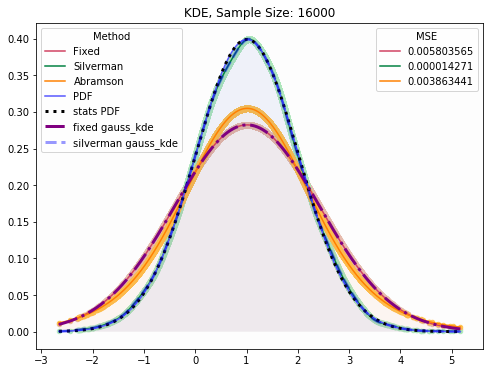


Time
-----------------------
PDF:        0.000136 s
KDE Fixed:  0.964509 s
Silverman:  0.985251 s
Abramson:   4.438570 s
Total:      6.388465 s
-----------------------


In [12]:
# plt.rcParams['figure.figsize'] = 8,6

sample_sizes = [200,500,1000,2000,3000,4000,5000,6000,8000,9000,10000,11000,13000,14000,15000,16000]
display_sample_sizes = [1000, 2000, 4000, 6000, 8000, 16000]
# sample_sizes = [1000]

mses = {'fixed': [], 'silverman': [], 'abramson': []}
colors = {'fixed':'#d04060','silverman':'#008040', 'abramson':'#ff8000', 'pdf':'#5555ff'}

for sample_size in sample_sizes:
    
    # PARAMETERS

#     sample_size = 2000 # number of samples
    point_size = 20 # size of points on plot

    # RUN MODELS (Regular, Vectorized)

    np.random.seed(1) # <-- SETS A RANDOM SEED
    samples = multivariate_normal(mean=[1], cov=[[1]], size=sample_size) # returns points in a normal distribution
    samples.sort(axis=0) # sorts points in distribution
    samples = samples.flatten()
    
    t = time.time()


    pdf_vals = pdf(samples);               t1 = time.time();
    fixed = KDE_fixed_arr(samples);        t2 = time.time();
    silver = KDE(samples, bw='silverman'); t3 = time.time();
    abram = KDE(samples, bw='abramson');   t4 = time.time();
#     silver2 = KDE(samples, bw='silverman2') # original silverman bandwidth equation
    
#     X = np.array(samples).reshape(-1,1)
#     skkde = KernelDensity(kernel='gaussian', bandwidth=np.std(X)).fit(X).score_samples(X)
    np.random.seed(1)
    pdf2_vals = stats.multivariate_normal.pdf(samples,mean=np.mean(samples),cov=[[1]])

    silv_gauss_kde = gaussian_kde(samples, bw_method='silverman', weights=None).evaluate(samples)
    fix_gauss_kde = gaussian_kde(samples, bw_method=np.std(samples), weights=None).evaluate(samples)
#     other = gaussian_kde(samples, bw_method=silver_band(len(samples),1), weights=None).evaluate(samples)
    t5 = time.time()


    # COMPUTE MSE

    mse_fixed = MSE(fixed, pdf_vals)
    mse_silver = MSE(silver, pdf_vals)
    mse_abram = MSE(abram, pdf_vals)
#     mse_other = MSE(other, pdf_vals)

    mses['fixed'] += [mse_fixed]
    mses['silverman'] += [mse_silver]
    mses['abramson'] += [mse_abram]


    # PLOT
    if sample_size in display_sample_sizes:
        print("_"*100)
        
        plt.figure(figsize=(8,6))
        
        # Fixed Plot
        plt.scatter(samples, fixed, s=point_size, color='#e6bbad')
        plt.plot(samples, fixed, color=colors['fixed'], linestyle='-', label='Fixed') # linestyle=':'

        # Silverman Plot
        plt.scatter(samples, silver, s=point_size, color='#ade6bb')
        plt.plot(samples, silver, color=colors['silverman'], linestyle='-', label='Silverman')
        
        # Silverman (original) Plot
#         plt.scatter(samples, silver2, s=point_size, color='gray',alpha=0.2)
#         plt.plot(samples, silver2, color='gray', linestyle='-', label='Silverman (original)')

        # Abramson Plot
        plt.scatter(samples, abram, s=point_size, color='#ffc04e')
        plt.plot(samples, abram, color=colors['abramson'], linestyle='-', label='Abramson')

    #     # Other Package KDE Plot
    #     plt.scatter(samples, other, s=point_size, label='other_kde', color='#b20000')
    #     plt.plot(samples, other, color='#ff0000', linestyle=':')

        # PDF Plot
        plt.plot(samples, pdf_vals, label='PDF', color=colors['pdf'], linestyle='-')
    #     plt.scatter(samples, pdf_vals, s=point_size, color='#99ccff')

    #### PLOTS FOR OTHER PACKAGES
    
        # PDF Plot
        plt.plot(samples, pdf2_vals, label='stats PDF', color='black', linestyle=':', linewidth=3)
    #     plt.scatter(samples, pdf_vals, s=point_size, color='#99ccff')
    
        # Fixed Plot
#         plt.scatter(samples, fix_gauss_kde, s=point_size, color='#e6bbad')
        plt.plot(samples, fixed, color='purple', linestyle='dashdot', label='fixed gauss_kde', linewidth=3) # linestyle=':'

        # Silverman Plot
#         plt.scatter(samples, silv_gauss_kde, s=point_size, color='#ade6bb')
        plt.plot(samples, silver, color='blue', linestyle='dashed', label='silverman gauss_kde', linewidth=3, alpha=0.4)
        
    

        plt.title(f"KDE, Sample Size: {sample_size}")
        plt.gca().add_artist(plt.legend([f"{mse_fixed:0.9f}", f"{mse_silver:0.9f}", f"{mse_abram:0.9f}"], loc=1, title='MSE'))
        plt.legend(loc='upper left',title="Method")
        plt.gca().set_facecolor('#fdfdfd')

        plt.fill_between(samples, 0, pdf_vals, facecolor=colors['pdf'],alpha=0.05)
        plt.fill_between(samples, 0, fixed, facecolor=colors['fixed'],alpha=0.02)
        plt.fill_between(samples, 0, silver, facecolor=colors['silverman'],alpha=0.02)
        plt.fill_between(samples, 0, abram, facecolor=colors['abramson'],alpha=0.03)
        
        plt.show()

    #     print("\nSample Size:", sample_size)
        print("\nTime"); 
        print("-"*23);
        print(f"PDF:        {t1-t:0.6f} s"); 
        print(f"KDE Fixed:  {t2-t1:0.6f} s"); 
        print(f"Silverman:  {t3-t2:0.6f} s");
        print(f"Abramson:   {t4-t3:0.6f} s"); 
    #     print(f"Other KDE:  {t5-t4:0.6f} s");
        print(f"Total:      {t4-t:0.6f} s")
        print("-"*23);

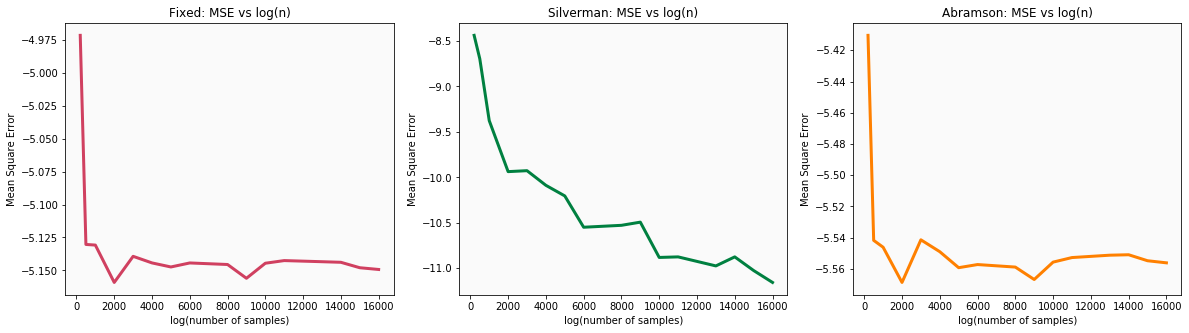

In [13]:
# plt.rcParams['figure.figsize'] = 20,5
plt.figure(figsize=(20,5))

method_names = ['Fixed', 'Silverman', 'Abramson']
# colors = {'fixed':'#d04060','silverman':'#62a40a', 'abramson':'#ffa501'}

for i in range(len(method_names)):
    method_name = method_names[i]
    ax = plt.subplot(f'13{i+1}')
    ax.plot(sample_sizes, np.log(mses[method_name.lower()]), color=colors[method_name.lower()], linewidth=3)
    ax.set_title(f"{method_name}: MSE vs log(n)")
    ax.set(ylabel="Mean Square Error", xlabel="log(number of samples)")
#     ax.ylabel("Mean Square Error")
#     ax.xlabel("log(number of samples)")
#     ax.gca().set_facecolor('#fafafa')
    ax.set_facecolor('#fafafa')
plt.show()

### Testing / Calculating Stuff by Hand

In [274]:
testB = np.array([1.,2.,3.])
testC = np.array([[1.,2.],[1.,2.],[1.,2.]])
test_a = np.array([0.15581735,0.1761232,0.15581735])
test_exp_denom = np.array([1.456719277,1.14018282,1.456719277])

# test_a = np.array([1.,2.,3.])
# test_exp_denom = np.array([1.,2.,3.])

In [231]:
type(testB[0])

numpy.float64

In [275]:
general_kde_loop_multidim(testC, test_a, test_exp_denom)

<class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'> <class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'> <class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'>


array([0.16849736, 0.19599422])

In [277]:
general_kde_loop_onedim(testB, test_a, test_exp_denom)

<class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'> <class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'> <class '_cython_magic_d869d8ff1d05a116880ee52ae4d66c62._memoryviewslice'>


array([0.23908793, 0.33298381, 0.23908793])

In [34]:
stats.multivariate_normal.pdf(np.array([1,2,3]),cov=[[1]])

array([0.24197072, 0.05399097, 0.00443185])

In [32]:
pdf(np.array([1.,2.,3.]))

array([0.23079948, 0.48860251, 0.23079948])

In [93]:
KDE(np.array([1.,2.,3.]),bw='abramson')

𝜎_i [0.85344003 0.75504398 0.85344003]


array([0.23908793, 0.33298384, 0.23908793])

In [290]:
# loops changed
KDE(np.array([1.,2.,3.]),bw='abramson')

<class '_cython_magic_be241ac07410a6fca445382cc45d1179._memoryviewslice'> <class '_cython_magic_be241ac07410a6fca445382cc45d1179._memoryviewslice'> <class '_cython_magic_be241ac07410a6fca445382cc45d1179._memoryviewslice'>


array([0.23908793, 0.33298384, 0.23908793])

In [59]:
KDE_fixed_arr(np.array([1.,2.,3.]))

array([0.24790936, 0.31673383, 0.24790936])

In [286]:
# loops changed
KDE_fixed_arr(np.array([1.,2.,3.]))

array([0.24790936, 0.31673383, 0.24790936])

In [23]:
KDE_fixed_arr(np.array([1.,2.,3.]))

array([0.24790936, 0.31673383, 0.24790936])

In [78]:
KDE(np.array([1.,2.,3.]),bw='abramson')

𝜎_i: [0.85344003 0.75504398 0.85344003]


array([0.23908793, 0.33298384, 0.23908793])

In [25]:
KDE(np.array([1.,2.,3.]),bw='silverman')

array([0.24455257, 0.31303691, 0.24455257])

In [ ]:

# sample_sizes = sorted(set(list(map(int,np.linspace(1,8000,num=10)))+sample_sizes))

### Misc. Functions

Recommended steps for implementing mathematical function in code:

    - ensure formula is correct
    - do problem by hand with simplified data
    - develop procedural pseudocode for solving problem
    - program each step of pseudocode
    - test each step: compare results with hand-calculated solution
    - optimize code for speed and memory
    - use program to calculate results with larger amounts of data
    - compute and display results

In [6]:
# USEFUL FUNCTIONS

def repeat(obj, n): 
    "Repeats obj n times; e.g., 1,4 -> [1,1,1,1]"
    return [obj for _ in range(n)]

def repeat_elem(arr, n): 
    "Repeats array elements in place n times; e.g., [1,2],2 -> [1,1,2,2]"
    # Note: Equivalent to flatten(transpose(repeat(arr, n)))"
    return [i for i in arr for _ in range(n)]

def cycle(arr, n): 
    "Cycles array elements n times; e.g., [1,2],2 -> [1,2,1,2]"
    # Note: Equivalent to flatten(repeat(arr, n))
    return [i for _ in range(n) for i in arr]

def flatten(A): 
    "Flattens a 2D list; e.g., [[1,2],[3]] -> [1,2,3]"
    return [a for subset in A for a in subset]

def transpose(A): 
    "Swaps dimensions of A; e.g., [[1,2],[3,4]] -> [[1,3],[2,4]]"
    return [list(a) for a in list(zip(*A))]

def ismulti(A): 
    "Checks if A is multi-dimensional; e.g., [[1,2],[3,4]] -> True; [1,2,3,4] -> False"
    return len(np.array(A).shape) > 1
    
def grab_idxs(A, idxs): 
    "Filters array A for indices in idxs"
    return [A[i] for i in range(len(A)) if i in idxs]

def take(n,A=None): 
    "Take the first n elements of A; e.g., [3,4,5,6],2 -> [3,4]" # grab_idxs(A, range(n))
    return [A[i] for i in range(n)] if A is not None else partial(lambda A: take(n,A))

def reverse(A): 
    "Reverses a list A"
    return A[::-1]

def evens(n): 
    "First n even integers; e.g., 3 --> [0,2,4]"
    return list(filter(lambda x: (x%2)==0, range(n*2)))

def odds(n): 
    "First n odd integers;  e.g., 3 --> [1,3,5]"
    return list(filter(lambda x: x%2, range(n*2+1)))

def arraymap(f, A): return np.array(list(map(f, A)))
def listmap(f,A): return list(map(f,A))

# def vec_norm(A): return np.linalg.norm(A) # implements vector norm of A

### Time Tracker

In [1]:
# RUN AT THE START OF A SESSION
from datetime import datetime

previous_running_total = 22025 # update this with New Running Total at end of session
start_time = datetime.utcnow()

session_start_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
session_date_string = datetime.now().strftime("%m/%d/%Y")

print(f"This session began on {session_start_string}")

This session began on 02/28/2020 13:22:08


In [102]:
# RUN TO UPDATE SESSION TIME ELAPSED
current_time = (datetime.utcnow()-start_time).seconds # time elapsed from start_time

def get_just_seconds(seconds): return seconds % 60
def get_minutes(seconds): return seconds//60 - (seconds//3600)*60
def get_hours(seconds): return seconds//3600 - (seconds//86400)*24
def get_days(seconds): return seconds//86400

seconds_elapsed = get_just_seconds(current_time)
minutes_elapsed = get_minutes(current_time)
hours_elapsed = get_hours(current_time)

prev_total_days = get_days(previous_running_total)
prev_total_hours = get_hours(previous_running_total)
prev_total_minutes = get_minutes(previous_running_total)
prev_total_seconds = get_just_seconds(previous_running_total)

running_total = current_time + previous_running_total

total_days = get_days(running_total)
total_hours = get_hours(running_total)
total_minutes = get_minutes(running_total)
total_seconds = get_just_seconds(running_total)

print(f'Time Spent \t \t \t{datetime.now().strftime("%m/%d/%Y %I:%M %p")}')
print("-"*52)
print(f"This Session:      {hours_elapsed} hours, {minutes_elapsed} minutes, {seconds_elapsed} seconds")
print(f"Previous Sessions: {prev_total_hours} hours, {prev_total_minutes} minutes, {prev_total_seconds} seconds")
print(f"All Sessions:      {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")
print(f"\nNew Running Total: {running_total}")

print("\n(Started recording sessions on 02/27/2020 13:29:29)")

Time Spent 	 	 	02/28/2020 03:33 PM
----------------------------------------------------
This Session:      2 hours, 11 minutes, 29 seconds
Previous Sessions: 3 hours, 55 minutes, 36 seconds
All Sessions:      6 hours, 7 minutes, 5 seconds

New Running Total: 22025

(Started recording sessions on 02/27/2020 13:29:29)


In [103]:
# RUN AT END OF SESSION
session_end_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

print(f"This session ended on {session_end_string}")

This session ended on 02/28/2020 15:33:43


### Other stuff

<b>Generic Gaussian Function</b>

A gaussian function is of the following form, where $a, b, $ and $ c$ are constants

$$g\left(x\right) = a \cdot exp{\left(-\dfrac{(x-b)^2}{2c^2}\right)}$$

Gaussian Function of Probability Density Function:

$$g(x) = \dfrac{1}{\sigma \sqrt{2\pi}} \cdot exp \left(-\dfrac{1}{2}\left(\dfrac{\bar{x}-x}{\sigma}\right)^2\right)$$

$\sigma$ : standard deviation, (bandwidth for a gaussian kernel) <br>
$\bar{x}$ : mean of x

<b>General KDE Formula:</b>

$$\hat{f}(x) = \dfrac{1}{nh}\sum_{i=1}^{n} K\left(\dfrac{\bar{x} - x_i}{h}\right)$$

K$\left(\cdot\right)$ : kernel function (e.g., gaussian) <br>
h : bandwidth; (for gaussian kernel, bandwidth is $\sigma$ of guassian distribution) <br>
$\bar{x}$ : mean of x

<b>Fixed General KDE (Gaussian Kernel):</b> <br>

$$\hat{f}(x) = \dfrac{1}{n} \sum_{i=1}^{n} \dfrac{1}{\sqrt{2\pi}\sigma^m}\cdot exp\left(\dfrac{{\Vert \bar{x} - x_i\Vert}^2}{2\sigma^2}\right)$$

$\sigma$ : standard deviation, (bandwidth for a gaussian kernel) <br>
m : dimension of vector space <br>
$\bar{x}$ : mean of x

<b>KDE Bandwidth: Silverman's Method</b>

Best Bandwidth Based on Silverman's Rule of Thumb:

$$h = \left(\dfrac{4\hat{\sigma}^5}{3n}\right)^{\tfrac{1}{5}}$$

$h$ : kernel bandwidth <br>
$\hat{\sigma}$ : sample standard deviation <br>
$n$ : sample size

<b>KDE Bandwidth: Abramson's Method</b>

Abramson's method uses variable bandwidths defined by:

$$\sigma_i = \sigma \cdot \left(\dfrac{\eta}{f_{fixed}(X_i)}\right)^{1/2}$$

$\sigma_i$ : Abramson bandwidth <br>
$\sigma$ : fixed bandwidth (default 1.0) <br>
$\eta$: mean of $f_{fixed}(X_i)$ <br>
$f_{fixed}(X_i)$ : fixed density estimation
